# LIBRARIES

In [18]:
import pickle
from Environment import *
from UserCat import UserCat
from Product import Product
from Greedy_optimizer import *
import numpy as np
import matplotlib.pyplot as plt
from step3_ucb1 import *
from step4_ucb1 import *
from step5_ucb1 import *
from Step3_TS import *
from Step4_TS import *
from Step5_TS import *

# ENVIRONMENT DEFINITION 

- Environment fixed informations and Products definition

In [19]:
np.random.seed(1)

products=[]

nameofproduct= [ #name of products
    "Calabazas",
    "Hinojo",
    "Sesamo",
    "Girasol",
    "Amapola"
]
# Dictionary fixing the secondary products linked to 
secondary_dict= {        
    "Calabazas": [1,2],
    "Hinojo": [0,2],
    "Sesamo": [1,3],
    "Girasol": [2,4],
    "Amapola": [2,3]
}

# Matrix n_prod*n_prices collecting the possible prices for each product. Prices are in ascending order
prices = [[8., 9, 10, 11],
          [10., 11, 12, 13],
          [20., 21, 23, 25],
          [28., 30, 31, 33],
          [40., 42, 43, 45]]
# Production cost of the products
cost = [5, 7.8, 18.1, 23.5, 32]

#sarebbe interessante anche prendere da file il tutto così da cambiare tutto più facilmente
#calcolo i margini dai cost mi sembra più sensato e anche più veloce se dobbiamo cambiare continuamente
# Computation of margins linked to each product for a particular choice of price
cost2 = np.tile(np.array([cost]).transpose(), (1, 4))
margins = np.array(prices)-cost2
# Creation of the 5 objects of Product class
for i in range (5):
    products.append(Product(prices[i], i, nameofproduct[i],margins[i]))

# Parameter for the computation of the click probability on the SECOND secondary product
lambda_q = 0.7

- User Category 1: Young and Inexpert

In [20]:
# Parameters for the distribution describing the reservation price
res_price_params_1 = {
    "mean": [9, 15, 22, 33, 35],
    "std": [1, 2, 1, 1.5, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_1 = [[0, 0.7, 0.3, 0, 0],
                 [0.6, 0, 0.5, 0, 0],
                 [0, 0.7, 0, 0.3, 0],
                 [0, 0, 0.4, 0, 0.1],
                 [0.5, 0, 0.3, 0, 0]]
prob_lambda_1 = lambda_correct(np.matrix(probabilities_1), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_1 = [15, 15, 10, 5, 5]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_1 = [2, 1, .5, .2, .1]

user1 = UserCat(alphas_1, res_price_params_1, poisson_lambda_1, prob_lambda_1)

- User Category 2: Old and Inexpert

In [21]:
# Parameters for the distribution describing the reservation price
res_price_params_2 = {
    "mean": [9, 16, 25, 41, 47],
    "std": [1, 2.5, 1.5, 3, 2]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_2 = [[0, 0.5, 0.4, 0, 0],
                 [0.4, 0, 0.6, 0, 0],
                 [0, 0.7, 0, 0.5, 0],
                 [0, 0, 0.5, 0, 0.3],
                 [0, 0, 0.5, 0.3, 0]]
prob_lambda_2 = lambda_correct(np.matrix(probabilities_2), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_2 = [7, 12, 12, 12, 7]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_2 = [0.5, 1, 2, 1, 0.5]

user2 = UserCat(alphas_2, res_price_params_2, poisson_lambda_2, prob_lambda_2)

- User Category 3: Expert

In [22]:
# Parameters for the distribution describing the reservation price
res_price_params_3 = {
    "mean": [8, 13, 24, 39, 50],
    "std": [1, 1.5, 2, 2, 1.5]
}
# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_3 = [[0, 0, 0.6, 0.4, 0],
                 [0, 0, 0, 0.7, 0.4],
                 [0, 0.4, 0, 0.6, 0],
                 [0, 0, 0.3, 0, 0.7],
                 [0, 0, 0.4, 0.6, 0]]
prob_lambda_3 = lambda_correct(np.matrix(probabilities_2), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_3 = [5, 5, 10, 15, 15]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_3 = [0.1, 0.2, 0.5, 1.5, 1.5]

user3 = UserCat(alphas_3, res_price_params_3, poisson_lambda_3, prob_lambda_3)

- User Category 0: Aggregated demand

In [23]:
# Parameters for the distribution describing the reservation price
res_price_params_0 = {
    "mean": [9.7, 12.7, 24.5, 31.6, 41.1],
    "std": [1.5, 2, 4, 2.5, 3]
}

# Matrix collecting the graph_weights describing mechanism of click on secondary products
probabilities_0 = [[0, 0.6, 0.2, 0, 0],
                 [0.5, 0, 0.4, 0, 0],
                 [0, 0.5, 0, 0.5, 0],
                 [0, 0, 0.6, 0, 0.5],
                 [0, 0, 0.3, 0.5, 0]]
prob_lambda_0 = lambda_correct(np.matrix(probabilities_0), secondary_dict, lambda_q)
# Parameter of the Dirichlet for the alphas ratio sampling
alphas_0 = [10, 10, 10, 10, 10]
# Parameter of the Poisson distribution determining the number of product bought
# ! we considered a trasleted Poisson in 1, to avoid the case of 0 items bought, so
#   the mean is poisson_lambda+1
poisson_lambda_0 = [1.5, 1, .5, .5, .2]

user0 = UserCat(alphas_0, res_price_params_0, poisson_lambda_0, prob_lambda_0)

- Environment creation

In [24]:
# CASE WITH 3 USERS :
# list of users 
users3 = [user1, user2, user3]
feature_matrix3 = np.array([[0, 1], [2, 2]])
# probability distribution of the feature
feature_prob = [0.3, 0.4]
env3 = Environment(users3, products, secondary_dict, feature_matrix3, feature_prob)

# CASE WITH AGGREGATED USER :
users0 = [user0]
feature_matrix0 = np.array([[0, 0], [0, 0]])
env = Environment(users0, products, secondary_dict, feature_matrix0, feature_prob)

In [ ]:
env.optimal_reward()

In [ ]:
env.expected_reward([2,3,2,1,0])

In [ ]:
np.matrix(env.theoretical_values['conversion_rates'][0])

In [ ]:
np.random.seed(0)
d = env3.simulate_day_context(200, [[0,0,0,0,0], [0,0,0,0,0], [0,0,0,0,0]], np.array([[0,1],[2,2]]), 
["conversion_rates", "alpha_ratios", "products_sold"])

In [ ]:
np.random.seed(0)
a = env3.simulate_day(2000, [0,0,0,0,0], ["conversion_rates", "alpha_ratios", "products_sold", "graph_weights"], aggregated= False)
a

- Reservation Price Distribution Plot for one user

In [ ]:
user_index = 0
x = np.arange(0, 60 , .01)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    res_price_distr = env.users[user_index].res_price_distr[i]
    y = res_price_distr.pdf(x)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])

for i in range(5):
    for j in range(4):
        plt.scatter(prices[i][j], 0.025, color = color_list[i])

plt.title("Reservation Price Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

* Number of Prouducts Sold Distributions Plot for a User

In [ ]:
user_index = 0
x = np.arange(0, 10, 1)
plt.figure(figsize=(12,7))

color_list = ['blue', 'orange', 'green', 'red', 'purple']

for i in range(5):
    pois_l = env.users[user_index].poisson_lambda[i]
    distr = scipy.stats.poisson(pois_l)
    y = distr.pmf(x[:-1])
    y = np.insert(y, 0, 0)
    plt.plot(x, y, label = 'Product %d' %i, color = color_list[i])
    #plt.scatter(x, y, color = color_list[i], label = 'Product %d' %i)
    #plt.vlines(x, 0, y, color = color_list[i], lw=5, alpha=0.5)

plt.title("Number of Prouducts Sold Distributions for the user category %s" %env.users[user_index].category)
plt.legend()
plt.show()

# Greedy Algorithm Example

In [ ]:
greedy_optimizer = Greedy_optimizer(env)
greedy_optimizer.run()

In [ ]:
env.optimal_reward()

# STEP 3 : Uncertain Convertion Rates

## - TS

In [ ]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta = [a, b]
learner = Step3_TS(env, initial_beta, learning_rate = 0.5)

In [ ]:
# set the parameter for the algorithm execution
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner.reward_history = []
learner.price_comb_history = []
learner.cr_matrix_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner.run(n_days, daily_users)

# collect all informations for the plot
opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ### Salvo la history su file in modo che siamo sicuri ti riuscire a recuperarla anche in un secondo momento

In [ ]:
with open('step3_rewards', 'wb') as f: 
    pickle.dump(collected_rewards, f)

- ### Per recuperare, invece, i risultati ottenuti in un secondo momento :

In [ ]:
with open('step3_rewards', 'rb') as f: 
    collected_rewards = pickle.load(f)

- ### Cumulative Regret Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

In [ ]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

### Explore the istant regret in the collected runs of the step 3 learner

In [ ]:
opt_reward = learner.opt_reward
(opt_reward - collected_rewards)[-2][-20:]

In [ ]:
learner.price_comb_history[-1][-20:]

- ### Comparison between mean conversion rates estimated by last run of TS and real values

In [ ]:
CR_mean = np.array(learner.cr_matrix_list).mean(axis = 0)
i = 9
CR_i = learner.cr_matrix_list[i]
print("Mean of estimated conversion rates \n", CR_mean)

print("\nEstimated conversion rates for run %d \n" %i, CR_i)

In [ ]:
np.matrix(env.theoretical_values['conversion_rates'][0])

In [ ]:
# CODICE PER TESTARE SE UN PREZZO PER UN DETERMINATO PRODOTTO E' STATO "ESPLORATO" DALL'ALGORITMO
comb_list = learner.price_comb_history[-1]
count = 0
prod = 0
price = 0

for comb in comb_list :
    count += 1 if comb[prod] == price else 0

count

## - UCB1

In [ ]:
# setting the run parameters
n_runs = 2
daily_users = 200
n_days = 300

In [ ]:
opt_reward = env.optimal_reward()[0]
ucb3 = step3_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb3.run(n_days, daily_users)

In [ ]:
# store the result
with open("ucb3", 'wb') as f1:
    pickle.dump(ucb3, f1)

In [ ]:
# load the result
with open("ucb3", 'rb') as f1:
    ucb3 = pickle.load(f1)

In [ ]:
step3_ucb1_collected_rewards = ucb3.collected_rewards
step3_ucb1_R = ucb3.regret
# plot of the result
mean_step3_ucb1_R = np.mean(step3_ucb1_R, axis=0)
std_dev_step3_ucb1 = np.std(step3_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step3_ucb1_R)
plt.fill_between(range(n_days), mean_step3_ucb1_R-std_dev_step3_ucb1, mean_step3_ucb1_R+std_dev_step3_ucb1, alpha=0.4)

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step3_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [ ]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb3.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

In [ ]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb3.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

In [ ]:
ucb3.print_estimations()

# STEP 4 : Uncertain conversion rates, alpha ratio and number of products sold

## - TS

In [ ]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a = np.ones((5,4))
b = np.ones((5,4))
initial_beta_CR = [a, b]
initial_beta_alpha = np.ones((2,5))
initial_n_prod_data = np.ones((2,5))
learner = Step4_TS(env, initial_beta_CR, initial_beta_alpha, initial_n_prod_data, learning_rate=0.5)

In [ ]:
# set the parameter for the algorithm execution
n_runs = 2
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner.reward_history = []
learner.price_comb_history = []
learner.cr_matrix_list = []
learner.alpha_ratios_list = []
learner.n_prod_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner.run(n_days, daily_users)

# collect all informations for the plot
opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ### Cumulative Regret Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

In [ ]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## - UCB1

In [ ]:
# setting the run parameters
n_runs = 2
daily_users = 200
n_days = 300

In [ ]:
opt_reward = env.optimal_reward()[0]
ucb4 = step4_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb4.run(n_days, daily_users)

In [ ]:
# store the result
with open("ucb4", 'wb') as f1:
    pickle.dump(ucb4, f1)

In [ ]:
# load the result
with open("ucb4", 'rb') as f1:
    ucb4 = pickle.load(f1)

In [ ]:
step4_ucb1_collected_rewards = ucb4.collected_rewards
step4_ucb1_R = ucb4.regret
# plot of the result
mean_step4_ucb1_R = np.mean(step4_ucb1_R, axis=0)
std_dev_step4_ucb1 = np.std(step4_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step4_ucb1_R)
plt.fill_between(range(n_days), mean_step4_ucb1_R-std_dev_step4_ucb1, mean_step4_ucb1_R+std_dev_step4_ucb1, alpha=0.4)

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step4_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [ ]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb4.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

In [ ]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb4.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

In [ ]:
ucb4.alphas[0]

In [ ]:
ucb4.print_estimations()

# STEP 5 : Uncertain conversion rates and graph weights

## - TS

In [ ]:
# Initial assumptions for beta parameters (uniform distr. on [0, 1])
a_cr = np.ones((5,4))
b_cr = np.ones((5,4))
initial_beta_CR = [a_cr, b_cr]
a_gw = np.ones((5,2))
b_gw = np.ones((5,2))
initial_beta_gw = [a_gw, b_gw]
learner = Step5_TS(env, initial_beta_CR, initial_beta_gw, learning_rate=0.5)

In [ ]:
# set the parameter for the algorithm execution
n_runs = 200
daily_users = 200
n_days = 300

# delete possible old informations form past runs 
learner.reward_history = []
learner.price_comb_history = []
learner.cr_matrix_list = []
learner.graph_weights_list = []

# execute the algorithm n_runs times
for i in range(n_runs) :
    learner.run(n_days, daily_users)

# collect all informations for the plot
opt_reward = learner.opt_reward
collected_rewards = learner.reward_history

- ### Cumulative Regret Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.title("Cumulative Regret")
plt.plot(np.cumsum(np.mean(opt_reward - collected_rewards, axis=0)), 'r')  #'r' stay for red, the color for the TS algorithm
plt.legend(["TS"])
plt.show()

- ### Standard Deviation Plot

In [ ]:
plt.figure(0)
plt.xlabel("t (days)")
plt.title("Regret's Standard Deviation")
plt.plot(np.std(opt_reward - collected_rewards, axis=0), 'r')  #'r' stay for red, the color for the TS algorithm
#plt.plot(np.std(opt - gr_rewards_per_experiment, axis=0), 'g')  #'g' stay for green, the color for the Greedy algorithm
plt.legend(["TS"])
plt.show()

In [ ]:
# mean_R = np.mean(R, axis=0)
cum_R = np.cumsum(opt_reward - collected_rewards, axis = 1)
mean_cum_R = np.mean(cum_R, axis = 0)
std_dev = np.std(cum_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_cum_R)
plt.fill_between(range(n_days), mean_cum_R-std_dev, mean_cum_R+std_dev, alpha=0.4)
plt.title("Cumulative Regret and its Std. Deviation")
plt.xlabel("t (days)")
plt.ylabel("Cum_Regret(t)")
plt.show()

- ### Comparison between Optimal and Expected Reward

In [ ]:
plt.figure(0)
plt.title("Optimal VS Expected Reward")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Expected Reward"])
plt.show()

## - UCB1

In [ ]:
# setting the run parameters
n_runs = 2
daily_users = 200
n_days = 300

In [ ]:
opt_reward = env.optimal_reward()[0]
ucb5 = step5_ucb1(len(prices), len(prices[0]), prices, env)
for _ in range(n_runs):
    ucb5.run(n_days, daily_users)

In [ ]:
# store the result
with open("ucb5", 'wb') as f1:
    pickle.dump(ucb5, f1)

In [ ]:
# load the result
with open("ucb5", 'rb') as f1:
    ucb5 = pickle.load(f1)

In [ ]:
step5_ucb1_collected_rewards = ucb5.collected_rewards
step5_ucb1_R = ucb5.regret
# plot of the result
mean_step5_ucb1_R = np.mean(step5_ucb1_R, axis=0)
std_dev_step5_ucb1 = np.std(step5_ucb1_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_step5_ucb1_R)
plt.fill_between(range(n_days), mean_step5_ucb1_R-std_dev_step5_ucb1, mean_step5_ucb1_R+std_dev_step5_ucb1, alpha=0.4)

In [ ]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.axhline(opt_reward, color = 'green')
plt.plot(np.mean(step5_ucb1_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()

In [ ]:
# last n pulled arms
print("Last n pulled arms:")
np.array(ucb5.pulled[-10:-1], dtype=np.int32)[:, 0].tolist()

In [ ]:
# ucb1 most pulled arms
combinations_data = [[] for i in range(1024)]
for i1 in range(4):
    for i2 in range(4):
        for i3 in range(4):
            for i4 in range(4):
                for i5 in range(4):
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append([i1, i2, i3, i4, i5])
                    c = np.array(np.array(ucb5.pulled, dtype=np.int32)[:, 0].tolist()) == [i1, i2, i3, i4, i5]
                    c = np.prod(c, axis=1)
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(np.count_nonzero(c))
                    combinations_data[i1*(4**4) + i2*(4**3) + i3*(4**2) + i4*(4**1) + i5*(4**0)].append(env.expected_reward([i1, i2, i3, i4, i5]))
                    x = combinations_data
result = []
for i in range(20):
    result.append(x[np.argmax(np.array(x)[:, 1])])
    x = np.delete(x, np.argmax(np.array(x)[:, 1]), axis=0).tolist()
print("Optimal arms combination:")
print(env.optimal_reward()[1], env.optimal_reward()[0])
print("\n\nUcb1 most pulled arms:")
print("(arms combination), (n° pulls), (exp rew)")
result

In [ ]:
ucb5.print_estimations()

## STEP 7: Context generation algorithms

In [ ]:
# step 7 --> daily users
feature_list = [[[0,1]], [[0,0],[1,0]], [[1,1]]]
learner_list = []
sampled_value_list = []
simul_info ->dict{'00' : dict( CR_matrix qui! )} # informazioni delle simulazioni dal giorno 0 al giorno t

# sample per ogni learner delle quantità incerte
for learner in learner_list :
    sampled_value_list[i]['CR'] =learner.sample_CR
    ..

# greedy optimizer per ogni context generato
for learner in learner_list :
    opt_price_comb[i] = greedy_optimizer(...)

# simulazione della giornata
daily_informations = simulate_day(daily_users, opr_price_comb_list, uncertain_list, context = feature_list)
->dict{'00' : dict(output simulate_day classico + count delle volte che la coppia di feature è uscita)}

# ! aggiornamento informazioni simulazione
simul_info.update(daily_informations, opt_price_comb_list) # update NON E' un append ma sommi i valori corrispondenti

# aggiornamento dei parametri:
for learner in learner_list :
    ... # rielaborazione di daily_information basa su feature_list (quindi aggreghi per context; aggregare = somma)
    learner.update_parameters(opt_price_combI, ...)

###### CONTEXT GENERATION ######
... > output: feature_list ...
# --> ridefinire learner_list in base al nuovo feature_list
# i parametri per beta o medie li prendiamo da simul info --> per le beta possiamo definire un "variability_rate" tra 0 e 1 
# per rimpicciolire i valori da mettere per A e B della beta (A e B matrici 5x4)


In [ ]:
simul_dict = {'00':{'alpha', 'CR', 'prod'}}
expected_reward(price_comb, uncertain, feature_list = [[0,1], [0,0]])

In [ ]:
learner.beta_parameters

In [ ]:
# parser matrice --> feature_list
n_groups = np.max(matrix)+1
feature_list = []
for i in len(n_groups):
    ind_list = return_indices(matrix, i)
    feature_list.append(list(feature_list))


# TEST ABRUBT CHANGES

In [8]:
from abrupt_test import *

In [28]:
n_runs = 20
daily_users = 200
n_days = 300

#########################
# ABRUPT CHANGE SETTING #
#########################
changes_dict ={      
    50 : {"mean": [9.0, 11.3, 23.2, 30.1, 39.7], "std": [1.3, 1.7, 3.5, 2.1, 2.7]},
    120 : {"mean": [10.5, 14.0, 25.8, 32.0, 43.0], "std": [1.7, 2.2, 4.3, 2.9, 3.2]},
    200 : {"mean": [9.7, 12.7, 24.5, 31.6, 41.1], "std": [1.5, 2, 4, 2.5, 3]}
}
opt_reward = env.optimal_reward()[0]
opt_reward_evolution = np.zeros(n_days)
original_res_price_param = copy.deepcopy(env.users[0].res_price_params)
for t in range(n_days):
    if t in changes_dict.keys(): 
        env.abrupt_change_deterministic([changes_dict[t]])
        opt_reward = env.optimal_reward()[0]
    opt_reward_evolution[t] = opt_reward

env.abrupt_change_deterministic([original_res_price_param])

In [29]:
ucb_changes = Abrupt_learner(len(prices), len(prices[0]), prices, env, changes_dict)
for _ in range(n_runs):
    ucb_changes.run(n_days, daily_users)

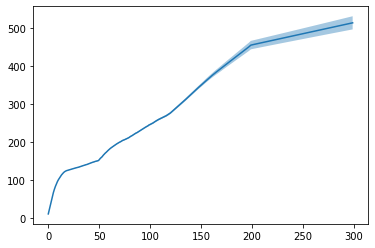

In [30]:
changes_collected_rewards = ucb_changes.collected_rewards
changes_R = ucb_changes.regret
# plot of the result
mean_changes_R = np.mean(changes_R, axis=0)
std_changes = np.std(changes_R, axis=0)/np.sqrt(n_runs)
plt.plot(mean_changes_R)
plt.fill_between(range(n_days), mean_changes_R-std_changes, mean_changes_R+std_changes, alpha=0.4)
plt.show()

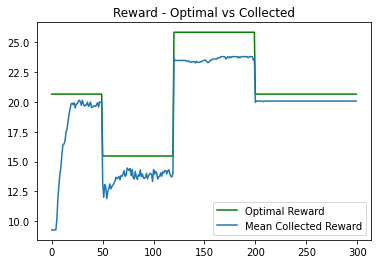

In [31]:
# comparison between optimal and expected reward
plt.figure(0)
plt.title("Reward - Optimal vs Collected")
plt.plot(opt_reward_evolution, color = 'green')
plt.plot(np.mean(changes_collected_rewards, axis=0))
plt.legend(["Optimal Reward", "Mean Collected Reward"])
plt.show()